# Ejercicios: notas de clase

## Paquetes y librerías

In [2]:
import warnings
import numpy as np
import pandas as pd
import mglearn

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, r2_score, precision_score,
    recall_score, f1_score, roc_auc_score, make_scorer, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
)

warnings.filterwarnings("ignore")


# 1. Breast Cancer

Dado que el tema de esta base de datos está relacionado con la salud, específicamente con el cáncer de mama, se ha considerado que la métrica más importante es `recall`. A nuestro parecer, esta resulta siendo la de mayor relevancia en este caso porque permite reducir los falsos negativos, lo cual es crucial en la detección del cáncer.

In [3]:
cancer = load_breast_cancer()

## KNN

### Gridsearch

In [4]:
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=cancer.target, random_state=21)

knn_pipeline = Pipeline([('scaler', MinMaxScaler()), ('KNN', KNeighborsClassifier())]) #Creación del Pipeline
knn_paramgrid = {'KNN__n_neighbors': list(range(1, 100))} #Parámetro grid

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 21)

knn_grid = GridSearchCV(knn_pipeline, knn_paramgrid, cv=kf, scoring='recall')
knn_grid.fit(X_train, y_train)

print("Mejor score de conjunto de entrenamiento : {:.2f}".format(knn_grid.best_score_))
print("Mejor parámetro: ", knn_grid.best_params_)

y_pred = knn_grid.predict(X_test) 
recall = recall_score(y_test, y_pred)

print('Mejor score de conjunto de test:',recall)

Mejor score de conjunto de entrenamiento : 1.00
Mejor parámetro:  {'KNN__n_neighbors': 43}
Mejor score de conjunto de test: 1.0


### Manual

In [5]:
def cross_val_recall(model, X, y, cv):
    kf = StratifiedKFold(n_splits = cv, shuffle = True, random_state = 21)
    recalls = []
    
    for train_index, test_index in kf.split(X, y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        scaler = MinMaxScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_test_fold = scaler.transform(X_test_fold)
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        
        recall = recall_score(y_test_fold, y_pred_fold)
        recalls.append(recall)

    return np.mean(recalls)

In [6]:
resultados = pd.DataFrame(columns=['recall'])
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=cancer.target, random_state=21)

for i in range(1, 100):
    model = KNeighborsClassifier(n_neighbors=i)
    recall = cross_val_recall(model, X_train, y_train, cv=5)
    resultados.loc[i] = recall

resultados

,recall
1,0.951433
2,0.936478
3,0.984976
4,0.973725
5,0.988749
...,...
95,0.992523
96,0.992523
97,0.992523
98,0.992523


In [7]:
max_recall = resultados.loc[resultados['recall'].idxmax()]

print("k = {} recall = {}".format(resultados['recall'].idxmax(), max_recall['recall']))


k = 43 recall = 1.0


Se puede notar que el máximo recall se obtiene para un modelo 43-NN con un recall de 1.

## Regresión Logística

### Gridsearch

In [8]:
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)

lr_pipe = Pipeline([('scaler', MinMaxScaler()), ('lr', LogisticRegression())]) 
lr_paramgrid = {'lr__C': [0.01, 0.1, 1, 10, 100]}

lr_grid = GridSearchCV(lr_pipe, lr_paramgrid, cv=5, scoring='recall')
lr_grid.fit(X_train, y_train)

y_pred = lr_grid.predict(X_test)
recall = recall_score(y_test, y_pred)

print("Mejor score de conjunto de entrenamiento: {:.2f}".format(lr_grid.best_score_))
print('Mejor score de conjunto de test:',recall)
print("Mejor parámetro: ", lr_grid.best_params_)

Mejor score de conjunto de entrenamiento: 1.00
Mejor score de conjunto de test: 1.0
Mejor parámetro:  {'lr__C': 0.01}


### Manual

In [9]:
def cross_val_recall(model, X, y, cv):
    kf = StratifiedKFold(n_splits = cv, shuffle = True, random_state = 21)
    recalls = []
    
    for train_index, test_index in kf.split(X, y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        scaler = MinMaxScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_test_fold = scaler.transform(X_test_fold)
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        
        recall = recall_score(y_test_fold, y_pred_fold)
        recalls.append(recall)

    return np.mean(recalls)

C = [0.01, 0.1, 1, 10, 100]
resultados = pd.DataFrame(columns=['C', 'recall'])

X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)

for c in C:  
    LR = LogisticRegression(C = c)
    recall = cross_val_recall(LR, X_train, y_train, cv = 5)
    fila  = pd.DataFrame({'C': [c], 'recall': [recall]})
    resultados = pd.concat([resultados, fila], ignore_index=True)

resultados

,C,recall
0,0.01,1.000000
1,0.10,0.992453
2,1.00,0.992453
3,10.00,0.984906
4,100.00,0.969811


In [10]:
mejor_parametro = resultados.loc[resultados['recall'].idxmax()]
print("Mejor parámetro C:", mejor_parametro['C'])
print('Mejor recall de entrenamiento:', mejor_parametro['recall'])

Mejor parámetro C: 0.01
Mejor recall de entrenamiento: 1.0


## Cuadro 1: Modelo de clasificación para detección de cancer de mama.

In [11]:
KNN1 = knn_grid.predict(X_test)
LR = lr_grid.predict(X_test)

# Evalua las predicciones en cada métrica con las etiquetas del test
metricas = {
    'Modelo': ['KNN', 'Regresión logística'],
    'Precision': [
        precision_score(y_test, KNN1), # K-NN
        precision_score(y_test, LR) # Regresión logística
    ],
    'Recall': [
        recall_score(y_test, KNN1),
        recall_score(y_test, LR)
    ],
    'F1 Score': [
        f1_score(y_test, KNN1),
        f1_score(y_test, LR)
    ],
    # En ROC AUC, No se tienen en cuenta las etiquetas sino las probabilidades
    'ROC AUC': [
        roc_auc_score(y_test, KNN1), 
        roc_auc_score(y_test, LR)  
    ]
}

cuadro1 = pd.DataFrame(metricas)
cuadro1

,Modelo,Precision,Recall,F1 Score,ROC AUC
0,KNN,0.939394,1.0,0.968750,0.94
1,Regresión logística,0.762295,1.0,0.865116,0.71


Si bien ambos modelos obtuvieron un recall de 1, es decir, perfecto. La precisión, F1 Score y ROC AUC de KNN fue mayor. Esto quiere decir que el modelo KNN tiene un mejor equilibrio entre precisión y recall, además de una mayor capacidad para distinguir entre categorías.

# 2. Boston Housing

## KNN


### Gridsearch

In [93]:
X, y = mglearn.datasets.load_extended_boston() #Conjunto de instancias y de etiquetas, respectivamente
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21) #Separamos por conjunto de entrenamiento y de prueba

In [94]:
knn_pipeline = Pipeline([('scaler', MinMaxScaler()), ('KNN', KNeighborsRegressor())]) #Creación del Pipeline
knn_paramgrid = {'KNN__n_neighbors': list(range(1, 100))} #Parámetro grid

knn_grid = GridSearchCV(knn_pipeline, knn_paramgrid, cv=10, scoring={'r2':'r2', 'neg_root_mean_squared_error':'neg_root_mean_squared_error'},refit='r2')
knn_grid.fit(X_train, y_train)

print("Mejor score conjunto de entrenamiento : {:.2f}".format(knn_grid.best_score_))
print("Mejor parámetro: ", knn_grid.best_params_)

#Predecimos el test con la misma métrica de entrenamiento
y_pred = knn_grid.predict(X_test) 
r_square = r2_score(y_test, y_pred)
rmse_ = np.sqrt(mean_squared_error(y_test, y_pred))

print('Mejor score en conjunto de test con R2:',r_square)
print('Mejor score en conjunto de test con RMSE:',rmse_)

Mejor score conjunto de entrenamiento : 0.72
Mejor parámetro:  {'KNN__n_neighbors': 2}
Mejor score en conjunto de test con R2: 0.7508025190433969
Mejor score en conjunto de test con RMSE: 4.598484858312136


### Manual

In [114]:
def cross_val_r2_rmse(model, X, y):
    kf = KFold(n_splits= 10, shuffle=True, random_state=21)
    r2_scores = []
    rmses = []

    for train_index, test_index in kf.split(X, y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        scaler = MinMaxScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_test_fold = scaler.transform(X_test_fold)

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        r2 = r2_score(y_test_fold, y_pred_fold)
        rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
        r2_scores.append(r2)
        rmses.append(rmse)
    return np.mean(r2_scores), np.mean(rmses)

In [117]:
resultados = pd.DataFrame(columns=['n_neighbors', 'r2', 'RMSE'])

X, y = mglearn.datasets.load_extended_boston()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)

for i in range(1, 100):
    model = KNeighborsRegressor(n_neighbors=i)
    r2, rmse = cross_val_r2_rmse(model, X_train, y_train)
    fila = pd.DataFrame({'n_neighbors': [i], 'r2': [r2], 'RMSE': [rmse]})
    resultados = pd.concat([resultados, fila], ignore_index=True)


max_r2 = resultados.loc[resultados['r2'].idxmax()]

print("k = {} r2 test = {:.2f} RMSE test = {:.2f}".format(max_r2['n_neighbors'], max_r2['r2'], max_r2['RMSE']))

k = 2 r2 test = 0.73 RMSE test = 4.64


In [118]:
resultados

,n_neighbors,r2,RMSE
0,1,0.694311,4.850379
1,2,0.731471,4.638933
2,3,0.728526,4.646957
3,4,0.692777,4.967366
4,5,0.660252,5.203002
...,...,...,...
94,95,0.363835,7.221236
95,96,0.361623,7.234575
96,97,0.359039,7.249247
97,98,0.356864,7.262003


## Regresión Linear

### Gridsearch

In [119]:
X, y = mglearn.datasets.load_extended_boston() #Conjunto de instancias y de etiquetas, respectivamente
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21) #Separamos por conjunto de entrenamiento y de prueba

In [74]:

lr_pipeline = Pipeline([('scaler', MinMaxScaler()),('lr', LinearRegression())])
lr_paramgrid = {} # No tiene hiperpárametros definidos

lr_grid = GridSearchCV(lr_pipeline, param_grid = lr_paramgrid, cv = 10, scoring= 'r2')
lr_grid.fit(X_train, y_train)

print("Mejor score (R2) en entrenamiento:", lr_grid.best_score_)

y_pred = lr_grid.predict(X_test)
r_square = r2_score(y_test, y_pred)
rmse_ = np.sqrt(mean_squared_error(y_test, y_pred))

print("R2 en el conjunto de test para Regresión Lineal:", r_square)
print("RMSE en el conjunto de test para Regresión Lineal:",rmse_)

Mejor score (R2) en entrenamiento: 0.8292541462054805
R2 en el conjunto de test para Regresión Lineal: 0.8040890774810361
RMSE en el conjunto de test para Regresión Lineal: 4.077296192955421


### Manual

In [120]:
X, y = mglearn.datasets.load_extended_boston() 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21) 

LR = LinearRegression()
r2, rmse = cross_val_r2_rmse(LR, X_train, y_train)

print(f'r2 test: {r2}     rmse test: {rmse}')

r2 test: 0.8188723320277056     rmse test: 3.743704151971437


## Cuadro 2: Modelo de regresión para Boston Housing.

In [21]:
# Se hacen las predicciones para poder comparar con las diferentes métricas
knr_predict= knn_grid.predict(X_test)
lr_predict = lr_grid.predict(X_test)

# Evalua las predicciones en cada métrica con las etiquetas del test
tabla2 = {
    'Modelo': ['K-NN', 'Regresión lineal'],
    'MAPE': [ # Error absoluto medio en porcentaje
        mean_absolute_percentage_error(y_test, knr_predict),
        mean_absolute_percentage_error(y_test, lr_predict)
    ],
    'MAE': [ # Error absoluto medio
        mean_absolute_error(y_test, knr_predict),
        mean_absolute_error(y_test, lr_predict)
    ],
    'RMSE': [ # Raíz cuadrada del error cuadrático medio
        np.sqrt(mean_squared_error(y_test, knr_predict)),
        np.sqrt(mean_squared_error(y_test, lr_predict))
    ],
    'MSE': [ # Error cuadrático medio
        mean_squared_error(y_test, knr_predict), 
        mean_squared_error(y_test, lr_predict)  
    ],
    'R2': [ # Coeficiente de determinación
        r2_score(y_test, knr_predict),
        r2_score(y_test, lr_predict)
    ]
}

cuadro2 = pd.DataFrame(tabla2)
cuadro2

,Modelo,MAPE,MAE,RMSE,MSE,R2
0,K-NN,0.152018,3.025984,4.598485,21.146063,0.750803
1,Regresión lineal,0.151045,2.649951,4.077296,16.624344,0.804089


R2 es la métrica que, entre las evaluadas, es la más cercana a 1. Para los datos tomados, el modelo de regresión lineal parece ajustarse mejor a los datos con el coeficiente de determinación. El MAPE es bastante similar, lo que indica que los errores de predicción parecidos en ambos modelos. Se nota también el modelo de regresión lineal tiene un error absoluto medio menor, es decir, sus predicciones son más precisas que las de K-NN , lo mismo sucede con RMSE y MSE. 

## Gráfico: Comparación precios originales con precios predichos.

Ahora, comparemos los precios originales con los predichos en ambos modelos.

### KNN

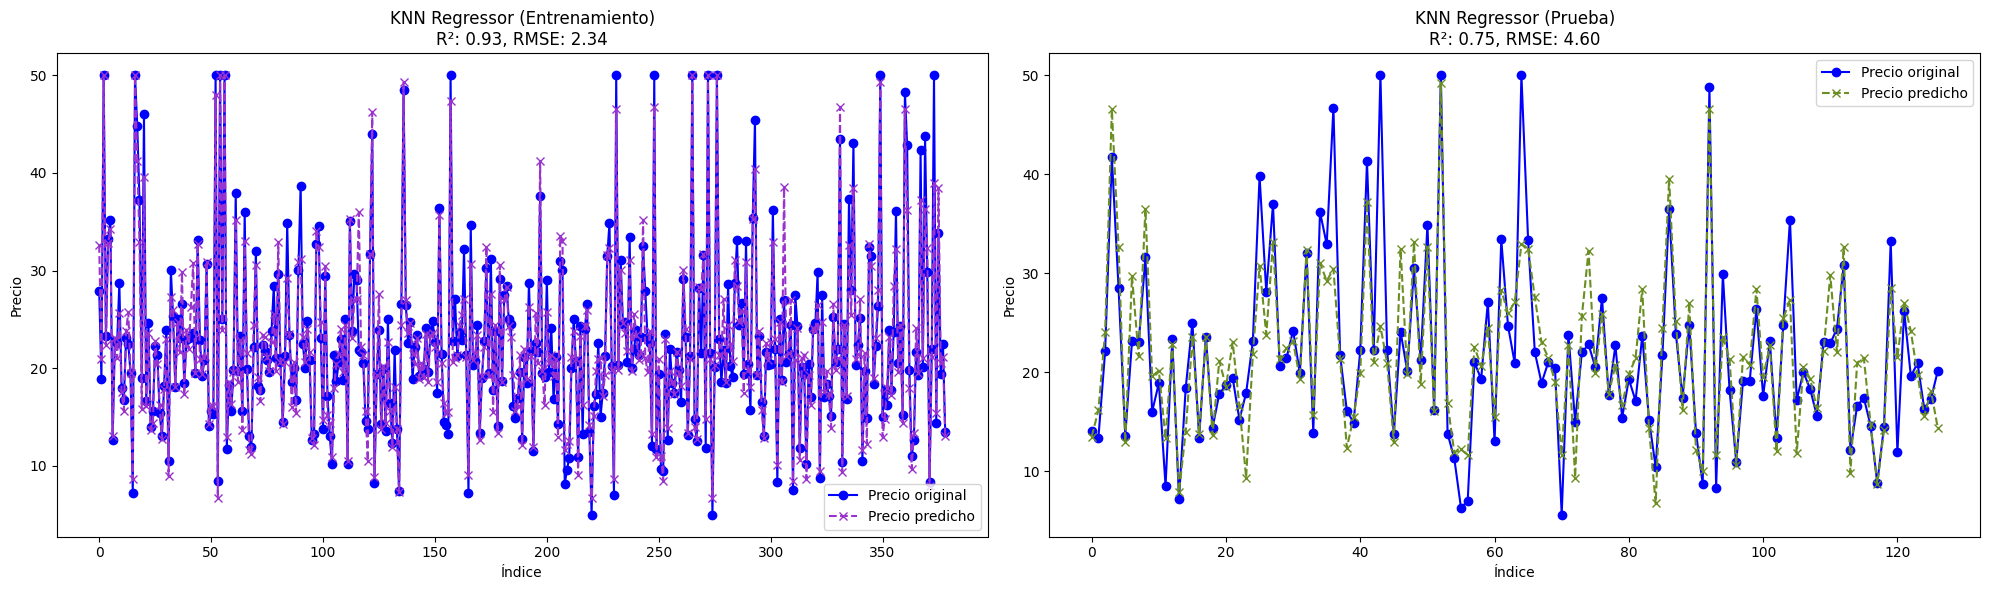

In [33]:
import numpy as np
import matplotlib.pyplot as plt

y_train_pred = knn_grid.predict(X_train)
y_test_pred = knn_grid.predict(X_test)

# Métricas
r2_train_knn = r2_score(y_train, y_train_pred)
r2_test_knn = r2_score(y_test, y_test_pred)

rmse_train_knn = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_knn = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Gráfico con lineplot
plt.figure(figsize=(20, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Precio original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_train_pred)), y_train_pred, label="Precio predicho", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Precio")
plt.title(f"KNN Regressor (Entrenamiento)\nR²: {r2_train_knn:.2f}, RMSE: {rmse_train_knn:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Precio original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_test_pred)), y_test_pred, label="Precio predicho", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Precio")
plt.title(f"KNN Regressor (Prueba)\nR²: {r2_test_knn:.2f}, RMSE: {rmse_test_knn:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()



Se nota que para los conjuntos de entrenamiento y prueba escogidos, el modelo KNNN tiene un mejor coeficiente de determinación y un menor RMSE en el conjunto de entrenamiento que en el de prueba. Viendo la distribución de las predicciones realizadas en el caso del conjunto de prueba, se puede notar que las predicciones realizadas no están tan alejadas de los precios reales. 

El modelo suele fallar un poco en la predicción de precios alto, entre los índices 20 y 40 hay varios precios altos que el modelo predice bastante más bajos. Esto con el conjunto de entrenamiento no pasa tan a menudo. 

### LR

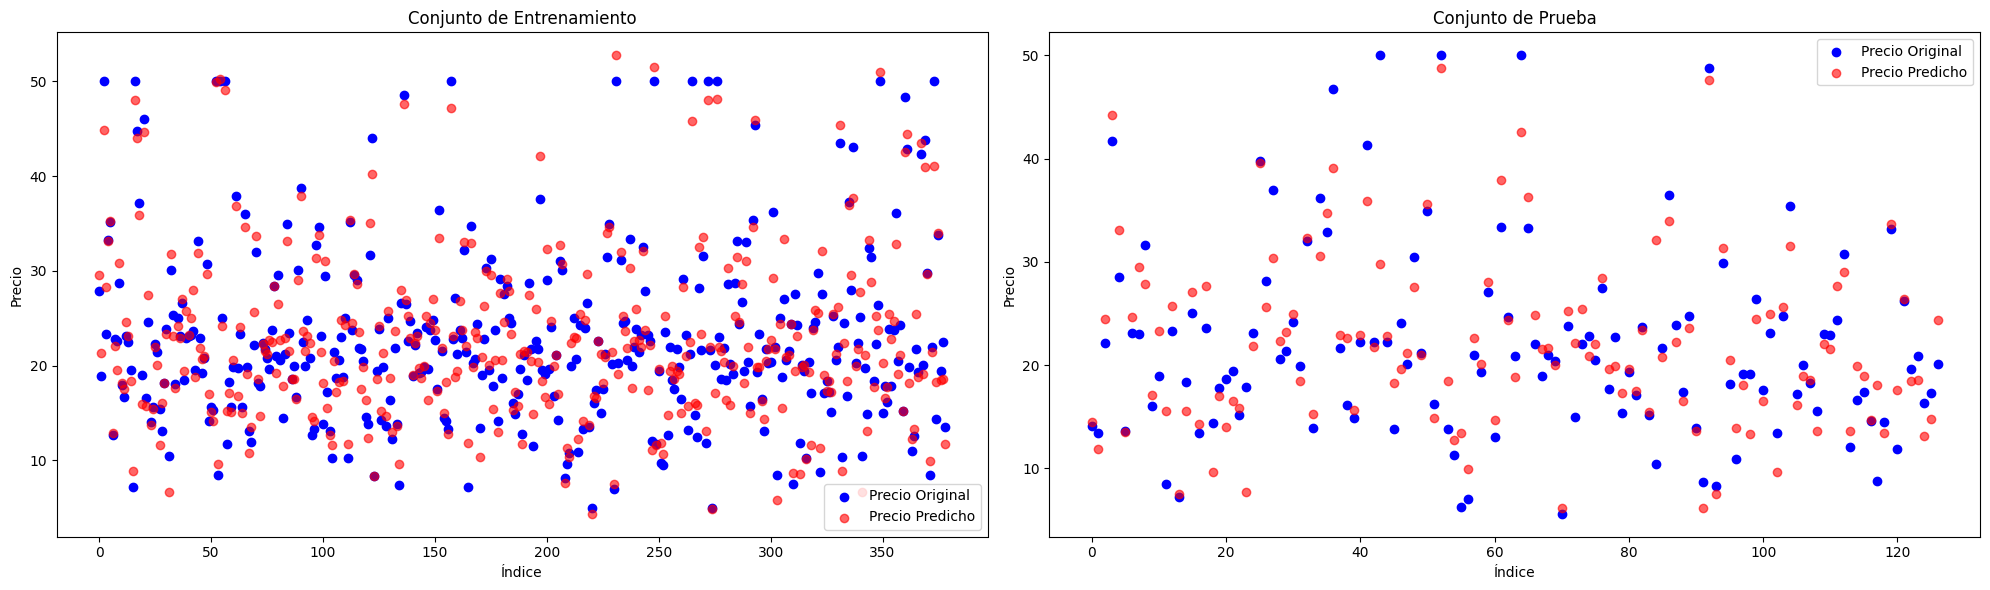

In [34]:
y_train_pred = lr_grid.predict(X_train)
y_test_pred = lr_grid.predict(X_test)

def plot_predictions(y_true_train, y_pred_train, y_true_test, y_pred_test):
    plt.figure(figsize=(20, 6))

    # Subplot para el conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(y_true_train)), y_true_train, color='blue', label='Precio Original')
    plt.scatter(range(len(y_pred_train)), y_pred_train, color='red', label='Precio Predicho', alpha=0.6)
    plt.xlabel('Índice')
    plt.ylabel('Precio')
    plt.title('Conjunto de Entrenamiento')
    plt.legend()

    # Subplot para el conjunto de prueba
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(y_true_test)), y_true_test, color='blue', label='Precio Original')
    plt.scatter(range(len(y_pred_test)), y_pred_test, color='red', label='Precio Predicho', alpha=0.6)
    plt.xlabel('Índice')
    plt.ylabel('Precio')
    plt.title('Conjunto de Prueba')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Crear el gráfico con Linear Regression
plot_predictions(y_train, y_train_pred, y_test, y_test_pred)
